In [2]:
# Load & Preprocess Data
import os
os.chdir(r"C:\Users\janar\OneDrive\Desktop\whatsapp")

import re
import pandas as pd
from datetime import timedelta
from datetime import datetime
import pytz

from fuzzywuzzy import fuzz

import numpy as np
from functools import reduce

import pandas as pd
from faker import Faker

# Function to extract data from each line
def extract_data(line):
    # Regular expression pattern to match timestamp, sender, and message
    pattern = r'\[(.*?)\] (.*?): (.*)'

    # Try to match the pattern
    match = re.match(pattern, line)

    if match:
        timestamp = match.group(1)
        sender = match.group(2)
        message = match.group(3)

        return timestamp, sender, message
    else:
        # Handle lines with the LEFT-TO-RIGHT EMBEDDING character
        pattern_rtl = r'‎\[(.*?)\] (.*?): (.*)'
        match_rtl = re.match(pattern_rtl, line)

        if match_rtl:
            timestamp = match_rtl.group(1)
            sender = match_rtl.group(2)
            message = match_rtl.group(3)

            return timestamp, sender, message
        else:
            return None

# Load the chat file
def load_chat(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            extracted = extract_data(line.strip())
            if extracted:
                data.append(extracted)

    # Create a DataFrame
    df = pd.DataFrame(data, columns=['PST_Date_Time', 'Sender', 'Message'])

    return df

# Example usage
file_path = 'data\carmel.txt'  # Update this path
df = load_chat(file_path)

#Anonymous Sender names
fake = Faker()
unique_senders = df['Sender'].unique()
# Generate a fake name for each unique sender
fake_names = {sender: fake.first_name() for sender in unique_senders}
df['Sender'] = df['Sender'].map(fake_names)

# # =============================================================================
# # Preprocess names
# # =============================================================================
# # Function to clean the sender names
# def clean_sender(sender):
#     # Remove tilde, quotes, and @ symbol
#     sender = sender.replace("~", "").replace("'", "").replace("'", "").replace('"', '').replace('@', '').replace('‘', '').replace('’', '')
    
#     # Remove any non-alphanumeric characters except for spaces, parentheses, and hyphens
#     #sender = re.sub(r'[^\w\s\(\)\-]', '', sender)
    
#     # Remove extra whitespaces
#     sender = re.sub(' +', ' ', sender)  # Replace multiple spaces with a single space
    
#     # Remove leading and trailing whitespaces
#     sender = sender.strip()
    
#     # Convert to string if not already
#     sender = str(sender)
    
#     return sender

# Apply the function to the 'Sender' column
# df['Sender'] = df['Sender'].apply(clean_sender)

# =============================================================================
# Convert DateTimePST to IST
# =============================================================================

def validate_and_convert_time(time_str):
    try:
        pst_datetime = datetime.strptime(time_str, "%m/%d/%y, %I:%M:%S %p")
        pst_tz = pytz.timezone('US/Pacific')
        pst_datetime_tz = pst_tz.localize(pst_datetime)
        ist_tz = pytz.timezone('Asia/Kolkata')
        ist_datetime = pst_datetime_tz.astimezone(ist_tz)
        return ist_datetime.strftime("%m/%d/%y, %I:%M:%S %p")
    except ValueError:
        return None

# Apply validation and conversion
df['IST_Date_Time'] = df['PST_Date_Time'].apply(validate_and_convert_time)

# Remove rows with None values (badly formatted)
df = df[df['IST_Date_Time'].notna()]

# =============================================================================
# Filter Messages for the year 2024
# =============================================================================
df['IST_Date_Time'] = pd.to_datetime(df['IST_Date_Time'], format='%m/%d/%y, %I:%M:%S %p')

# Filter rows where the year is 2024
#df_2024 = df[df['IST_Date_Time'].dt.year.isin([2024])]
df_2024 = df

# =============================================================================
# Remove Wishes and Greeting
# =============================================================================

# Define a list of common wishes
wishes = ["happy birthday", "happy new year", "get well soon", "merry christmas", "happy diwali", "happy christmas"]

# Function to check if a message contains wishes using fuzzy matching
def contains_wishes_fuzzy(message):
    '''
    Fuzzy Matching Metrics:

    fuzz.ratio(message.lower(), wish): Calculates a simple ratio of matching characters in the two strings. It's sensitive to the order of characters.
    
    fuzz.partial_ratio(message.lower(), wish): Similar to ratio, but it also considers the best matching substring, which can be useful for detecting partial matches.
    
    fuzz.token_sort_ratio(message.lower(), wish): This metric sorts the tokens (words) in both strings alphabetically and then compares them. It's useful for detecting matches even when word order is different.
    
    Thresholds:
    
    The function uses thresholds to determine if a match is significant enough to be considered a wish. These thresholds are:
    
    ratio > 60: A basic match ratio threshold. If the simple ratio is above 60, it's considered a match.
    
    partial_ratio > 80 or token_sort_ratio > 80: These are more stringent thresholds for partial matches or matches with different word orders. If either of these ratios exceeds 80, it's considered a match.

    '''
    for wish in wishes:
        ratio = fuzz.ratio(message.lower(), wish)
        partial_ratio = fuzz.partial_ratio(message.lower(), wish)
        token_sort_ratio = fuzz.token_sort_ratio(message.lower(), wish)
        
        # Adjust these thresholds as needed
        if ratio > 60 or partial_ratio > 80 or token_sort_ratio > 80:
            return True
    return False

# Apply the function to filter out messages with wishes
df_2024 = df_2024[~df_2024['Message'].apply(contains_wishes_fuzzy)]
#df_filtered.to_csv("carmel_filtered.csv")

# =============================================================================
# Filter out images, Audio and Video
# =============================================================================
exclude_values = ["image omitted", "video omitted", "audio omitted", "GIF omitted", "sticker omitted", "This message was deleted."]
df_2024['Message'] = df_2024['Message'].str.strip()
df_2024['Message'] = df_2024['Message'].str.replace(r'\u200e', '', regex=True)
df_2024['Message'] = df_2024['Message'].str.replace('<This message was edited>', '')

df_2024 = df_2024[~df_2024['Message'].isin(exclude_values)]

# =============================================================================
# Filter out rows with link
# =============================================================================
# Define a function to check if the cell contains only a link
def is_link_only(cell):
    return cell.startswith(('http', 'www')) and ' ' not in cell

# Filter rows where the column does not contain only links
df_2024 = df_2024[~df_2024['Message'].apply(is_link_only)]

# =============================================================================
# Rename columns
# =============================================================================
# Rename columns
new_columns = {
    'IST_Date_Time': 'Timestamp',
    'Sender': 'Sender',
    'Message': 'Message'
}

df_2024 = df_2024.rename(columns=new_columns)

C:\Users\janar\AppData\Local\Temp\ipykernel_33760\1807658013.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2024['Message'] = df_2024['Message'].str.strip()
C:\Users\janar\AppData\Local\Temp\ipykernel_33760\1807658013.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2024['Message'] = df_2024['Message'].str.replace(r'\u200e', '', regex=True)
C:\Users\janar\AppData\Local\Temp\ipykernel_33760\1807658013.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [21]:
#Keep a copy of the data in other dataframe (df)
import pandas as pd
from datetime import datetime

df = df_2024
df_org = df_2024
print(df.head())

          PST_Date_Time   Sender  \
0  2/10/14, 10:44:25 AM    Ricky   
1  2/10/14, 10:44:25 AM  Kaitlin   
2    9/7/18, 3:10:23 PM    Ricky   
3    9/7/18, 3:17:38 PM   Steven   
4    9/7/18, 3:18:01 PM     Mary   

                                             Message           Timestamp  \
0  Messages and calls are end-to-end encrypted. N... 2014-02-11 00:14:25   
1             ~ Vivek Vidhyasagar created this group 2014-02-11 00:14:25   
2                                 ~ Vigith added you 2018-09-08 03:40:23   
3              ~ Vigith added ~ Rejeesh Selvaganesan 2018-09-08 03:47:38   
4                       Welcome Shaja and Reejesh 💐💐 2018-09-08 03:48:01   

   Hour        Date  
0     0  2014-02-11  
1     0  2014-02-11  
2     3  2018-09-08  
3     3  2018-09-08  
4     3  2018-09-08  


In [22]:
import pandas as pd
import numpy as np
from scipy.stats import poisson
from datetime import datetime, timedelta
from scipy.spatial.distance import jensenshannon

# --- Sleep Pattern Detection ---
def detect_sleep_pattern(user_df):
    hourly_activity = user_df.groupby(user_df['Timestamp'].dt.hour).size().reindex(range(0, 24), fill_value=0)
    night_window = hourly_activity.loc[[*range(20, 24), *range(0, 9)]]
    threshold = np.percentile(night_window, 25)
    low_activity_hours = night_window[night_window <= threshold].index
    if len(low_activity_hours) >= 4:
        start_hour = min(low_activity_hours)
        end_hour = max(low_activity_hours)
        return (start_hour, end_hour)
    else:
        min_activity_hour = night_window.idxmin()
        return (min_activity_hour, (min_activity_hour + 5) % 24)

# --- Markov Transition Matrix Builder ---
def build_transition_matrix(df):
    df = df.sort_values('Timestamp')
    transitions = {}
    for hour in range(24):
        hour_df = df[df['Timestamp'].dt.hour == hour]
        users = df['Sender'].unique()
        matrix = pd.DataFrame(0, index=users, columns=users)
        for i in range(1, len(hour_df)):
            prev_user = hour_df.iloc[i-1]['Sender']
            curr_user = hour_df.iloc[i]['Sender']
            matrix.loc[prev_user, curr_user] += 1
        row_sums = matrix.sum(axis=1).replace(0, 1)
        transitions[hour] = matrix.div(row_sums, axis=0)
    return transitions

# --- Hourly Reply Probability Matrix ---
def hourly_reply_probability_advanced(df, reply_window_minutes=60, cluster_interval=30):
    df = df.sort_values('Timestamp').reset_index(drop=True)
    df['Hour'] = df['Timestamp'].dt.hour
    users = df['Sender'].unique()
    hours = range(24)
    sleep_windows = {}
    for user in users:
        user_df = df[df.Sender == user]
        start_hour, end_hour = detect_sleep_pattern(user_df)
        sleep_windows[user] = (start_hour, end_hour)
    clusters = []
    current_cluster = []
    last_timestamp = None
    for index, row in df.iterrows():
        if not current_cluster:
            current_cluster.append(row)
            last_timestamp = row['Timestamp']
        else:
            time_diff = (row['Timestamp'] - last_timestamp).total_seconds() / 60
            if time_diff <= cluster_interval:
                current_cluster.append(row)
                last_timestamp = row['Timestamp']
            else:
                clusters.append(current_cluster)
                current_cluster = [row]
                last_timestamp = row['Timestamp']
    if current_cluster:
        clusters.append(current_cluster)
    reply_counts = pd.DataFrame(0, index=users, columns=hours)
    opportunity_counts = pd.DataFrame(0, index=users, columns=hours)
    for cluster in clusters:
        cluster_df = pd.DataFrame(cluster)
        skip_cluster = False
        for idx, row in cluster_df.iterrows():
            sender = row['Sender']
            start_hour, end_hour = sleep_windows[sender]
            hour = row['Timestamp'].hour
            if ((start_hour < end_hour and start_hour <= hour < end_hour) or 
                (start_hour > end_hour and (hour >= start_hour or hour < end_hour))):
                skip_cluster = True
                break
        if skip_cluster:
            continue
        for i in range(1, len(cluster_df)):
            prev_row = cluster_df.iloc[i-1]
            curr_row = cluster_df.iloc[i]
            prev_user = prev_row['Sender']
            curr_user = curr_row['Sender']
            curr_hour = curr_row['Hour']
            if prev_user == curr_user:
                continue
            time_gap = (curr_row['Timestamp'] - prev_row['Timestamp']).total_seconds() / 60
            opportunity_counts.at[curr_user, curr_hour] += 1
            if time_gap <= reply_window_minutes:
                reply_counts.at[curr_user, curr_hour] += 1
    prob_matrix = reply_counts.div(opportunity_counts.replace(0, np.nan)).fillna(0)
    return prob_matrix

# --- Hourly Message Count Matrix ---
def hourly_message_count_matrix(df):
    df['Hour'] = df['Timestamp'].dt.hour
    count_series = df.groupby(['Sender', 'Hour']).size()
    count_matrix = count_series.unstack(fill_value=0)
    for h in range(24):
        if h not in count_matrix.columns:
            count_matrix[h] = 0
    count_matrix = count_matrix[sorted(count_matrix.columns)]
    return count_matrix

# --- Calibrate Reply Probability ---
def calibrate_reply_probability(prob_matrix, real_reply_ratio, sim_reply_ratio, min_prob=0.01, max_prob=0.99):
    if sim_reply_ratio == 0:
        scale = 1
    else:
        scale = real_reply_ratio / sim_reply_ratio
    new_matrix = prob_matrix * scale
    return new_matrix.clip(lower=min_prob, upper=max_prob)

# --- Enhanced & Calibrated Simulation Function (with total count and date fix) ---
def enhanced_simulator(df, prob_matrix, count_matrix, transitions):
    df['Date'] = df['Timestamp'].dt.date
    real_daily_counts = df.groupby('Date').size().to_dict()
    # Use actual min and max dates from the data
    min_date = df['Date'].min()
    max_date = df['Date'].max()
    days = pd.date_range(start=min_date, end=max_date, freq='D')
    users = count_matrix.index
    sleep_windows = {user: detect_sleep_pattern(df[df['Sender'] == user]) for user in users}
    simulated = []
    last_sender = None
    last_timestamp = None
    reply_count = 0
    total_count = 0

    for day in days:
        day_date = day.date()  # Ensure this is a datetime.date object
        n_msgs = real_daily_counts.get(day_date, 0)
        if n_msgs == 0:
            continue
        # Build a pool of (hour, user) slots for this day, with weights
        slots = []
        weights = []
        for hour in range(24):
            for user in users:
                start, end = sleep_windows[user]
                if (start < end and start <= hour < end) or (start > end and (hour >= start or hour < end)):
                    continue
                w = count_matrix.loc[user, hour]
                if w > 0:
                    slots.append((hour, user))
                    weights.append(w)
        weights = np.array(weights)
        if weights.sum() == 0 or len(slots) == 0:
            continue
        probs = weights / weights.sum()
        # Sample with replacement to match the real number of messages for this day
        sampled_indices = np.random.choice(len(slots), size=n_msgs, replace=True, p=probs)
        sampled_slots = [slots[i] for i in sampled_indices]
        # Shuffle to randomize order
        np.random.shuffle(sampled_slots)
        for hour, user in sampled_slots:
            minute = np.random.randint(0, 60)
            second = np.random.randint(0, 60)
            timestamp = datetime(day.year, day.month, day.day, hour, minute, second)
            # Reply logic
            is_reply = False
            if last_sender and last_sender != user:
                reply_prob = prob_matrix.loc[user, hour]
                if np.random.rand() < reply_prob:
                    trans_probs = transitions[hour].loc[last_sender]
                    if trans_probs.sum() > 0:
                        recipient = np.random.choice(trans_probs.index, p=trans_probs.values)
                        if recipient != user:
                            msg_type = f"Reply to {last_sender}"
                            is_reply = True
            if is_reply:
                simulated.append({'Sender': user, 'Message': f"Reply to {last_sender}", 'Timestamp': timestamp})
                reply_count += 1
            else:
                simulated.append({'Sender': user, 'Message': "New conversation", 'Timestamp': timestamp})
            total_count += 1
            last_sender = user
            last_timestamp = timestamp
    sim_df = pd.DataFrame(simulated).sort_values('Timestamp').reset_index(drop=True)
    sim_reply_ratio = reply_count / total_count if total_count else 0
    return sim_df, sim_reply_ratio

# --- Validation Metrics ---
def calculate_metrics(real_df, sim_df):
    metrics = {}
    real_hourly = real_df.groupby(real_df['Timestamp'].dt.hour).size()
    sim_hourly = sim_df.groupby(sim_df['Timestamp'].dt.hour).size()
    metrics['hourly_pearson'] = real_hourly.corr(sim_hourly)
    real_daily = real_df.groupby(real_df['Timestamp'].dt.date).size()
    sim_daily = sim_df.groupby(sim_df['Timestamp'].dt.date).size()
    metrics['daily_pearson'] = real_daily.corr(sim_daily)
    real_users = real_df['Sender'].value_counts(normalize=True)
    sim_users = sim_df['Sender'].value_counts(normalize=True)
    all_users = real_users.index.union(sim_users.index)
    real_aligned = real_users.reindex(all_users, fill_value=0)
    sim_aligned = sim_users.reindex(all_users, fill_value=0)
    metrics['js_divergence'] = jensenshannon(real_aligned, sim_aligned)
    real_replies = real_df['Message'].str.contains('Reply').mean()
    sim_replies = sim_df['Message'].str.contains('Reply').mean()
    metrics['reply_ratio_diff'] = abs(real_replies - sim_replies)
    return metrics

# --- USAGE EXAMPLE ---
# df = pd.read_csv('your_data.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
prob_matrix = hourly_reply_probability_advanced(df)
count_matrix = hourly_message_count_matrix(df)
transitions = build_transition_matrix(df)

# 1. Get real reply ratio
real_reply_ratio = df['Message'].str.contains('Reply').mean()
# 2. Simulate once to get sim reply ratio
sim_df, sim_reply_ratio = enhanced_simulator(df, prob_matrix, count_matrix, transitions)
# 3. Calibrate reply probability matrix
prob_matrix_calibrated = calibrate_reply_probability(prob_matrix, real_reply_ratio, sim_reply_ratio)
# 4. Simulate again with calibrated reply probability
sim_df, sim_reply_ratio = enhanced_simulator(df, prob_matrix_calibrated, count_matrix, transitions)

metrics = calculate_metrics(df, sim_df)
print(f"Hourly Correlation: {metrics['hourly_pearson']:.2%}")
print(f"Daily Correlation: {metrics['daily_pearson']:.2%}")
print(f"User Distribution Similarity: {metrics['js_divergence']:.4f}")
print(f"Reply Ratio Difference: {metrics['reply_ratio_diff']:.4f}")

print("\nSample Simulated Messages:")
print(sim_df.head(10))

print(f"\nTotal simulated messages: {len(sim_df)} (should match real data: {len(df)})")

Hourly Correlation: 99.04%
Daily Correlation: 100.00%
User Distribution Similarity: 0.2273
Reply Ratio Difference: 0.0078

Sample Simulated Messages:
     Sender           Message           Timestamp
0   Adriana  New conversation 2014-02-11 09:16:21
1    Rhonda  New conversation 2014-02-11 10:27:25
2     April  New conversation 2018-09-08 09:57:08
3     Sarah  New conversation 2018-09-08 09:57:55
4  Michelle  New conversation 2018-09-08 11:17:03
5     James  New conversation 2018-09-08 11:54:41
6   Adriana  New conversation 2018-09-08 11:58:48
7     Sarah  New conversation 2018-09-08 12:03:51
8     Scott  New conversation 2018-09-08 12:18:58
9     Sarah  New conversation 2018-09-08 12:49:32

Total simulated messages: 74742 (should match real data: 74742)


In [23]:
#Export Simulated Dataframe
sim_df.to_csv("sim_df.csv")

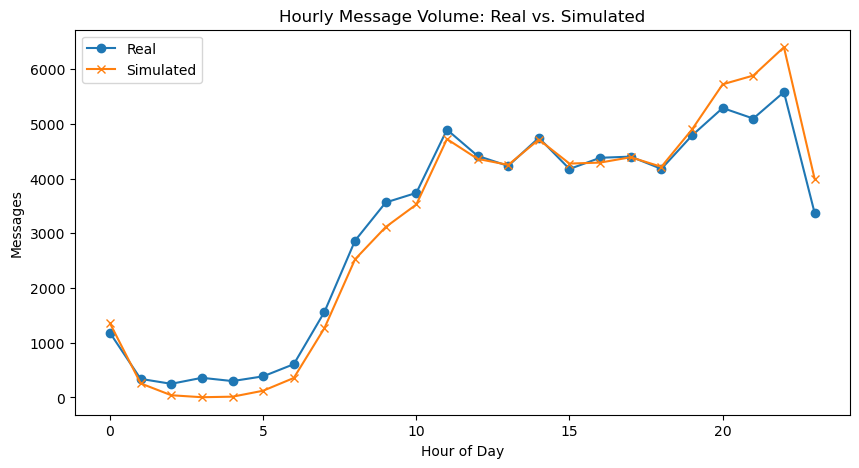

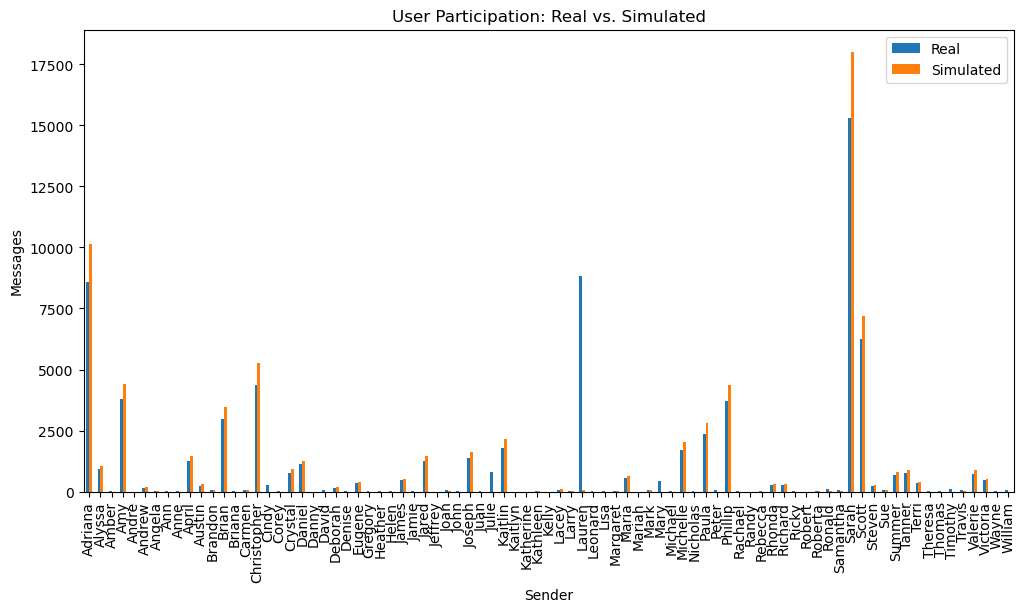

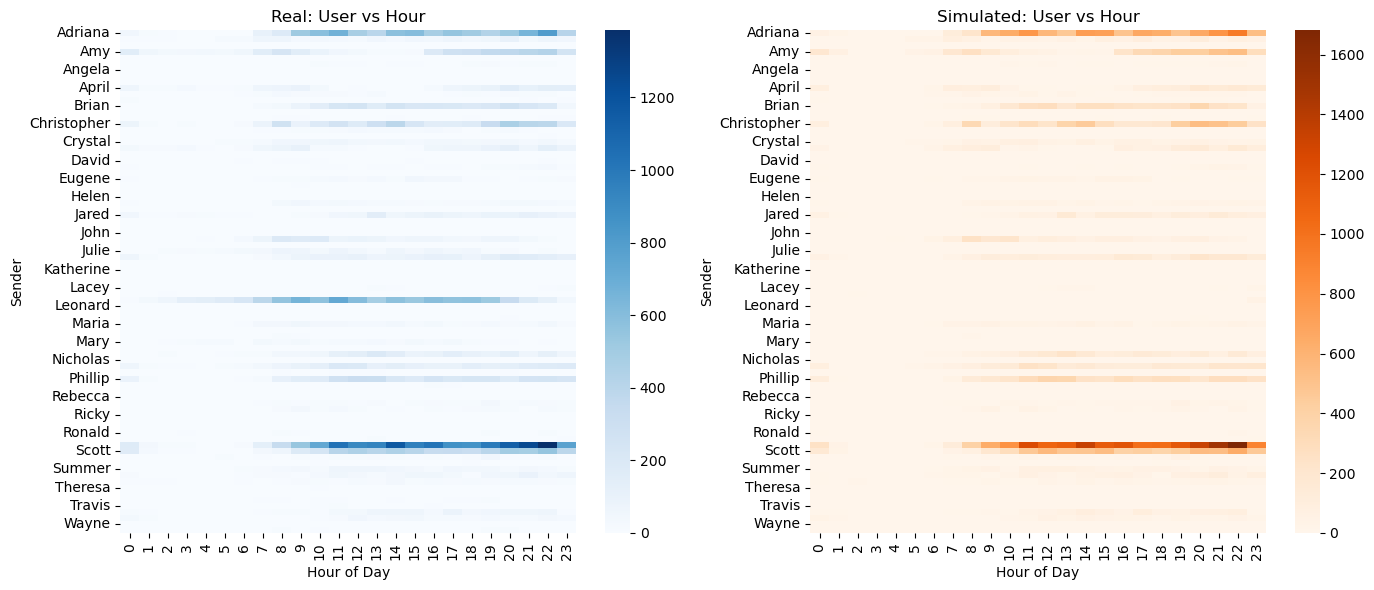

In [24]:
#Real Data vs Simulated Data - Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Hourly message volume
real_hourly = df.groupby(df['Timestamp'].dt.hour).size()
sim_hourly = sim_df.groupby(sim_df['Timestamp'].dt.hour).size()

plt.figure(figsize=(10,5))
plt.plot(real_hourly.index, real_hourly.values, label='Real', marker='o')
plt.plot(sim_hourly.index, sim_hourly.values, label='Simulated', marker='x')
plt.xlabel('Hour of Day')
plt.ylabel('Messages')
plt.title('Hourly Message Volume: Real vs. Simulated')
plt.legend()
plt.show()

# User participation (bar chart)
real_user = df['Sender'].value_counts()
sim_user = sim_df['Sender'].value_counts()
user_compare = pd.DataFrame({'Real': real_user, 'Simulated': sim_user}).fillna(0)
user_compare.plot(kind='bar', figsize=(12,6))
plt.title('User Participation: Real vs. Simulated')
plt.ylabel('Messages')
plt.show()

# Heatmap: user vs. hour
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure df and sim_df are loaded and contain 'Sender', 'Timestamp', and 'Message' columns

# Create pivot tables
real_pivot = pd.pivot_table(df, index='Sender', columns=df['Timestamp'].dt.hour, values='Message', aggfunc='count', fill_value=0)
sim_pivot = pd.pivot_table(sim_df, index='Sender', columns=sim_df['Timestamp'].dt.hour, values='Message', aggfunc='count', fill_value=0)

# Align user indices (union of users in both datasets)
all_users = real_pivot.index.union(sim_pivot.index)
real_aligned = real_pivot.reindex(all_users, fill_value=0)
sim_aligned = sim_pivot.reindex(all_users, fill_value=0)

# Plot aligned heatmaps
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.heatmap(real_aligned, cmap='Blues')
plt.title('Real: User vs Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Sender')

plt.subplot(1,2,2)
sns.heatmap(sim_aligned, cmap='Oranges')
plt.title('Simulated: User vs Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Sender')

plt.tight_layout()
plt.show()

C:\Users\janar\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\janar\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


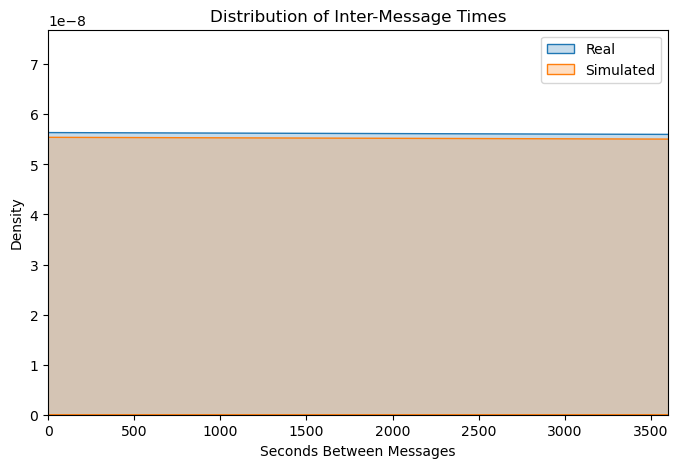

In [25]:
real_times = df['Timestamp'].sort_values().diff().dt.total_seconds().dropna()
sim_times = sim_df['Timestamp'].sort_values().diff().dt.total_seconds().dropna()
plt.figure(figsize=(8,5))
sns.kdeplot(real_times, label='Real', fill=True)
sns.kdeplot(sim_times, label='Simulated', fill=True)
plt.xlim(0, 3600)  # Focus on gaps up to 1 hour
plt.xlabel('Seconds Between Messages')
plt.ylabel('Density')
plt.title('Distribution of Inter-Message Times')
plt.legend()
plt.show()

In [26]:
## Simulate Reply pattern
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# ==================================================================
# 1. Core Pattern Detection (Sleep/Work Hours, Reply Probabilities)
# ==================================================================

def detect_activity_patterns(df):
    """Derive sleep/work hours and reply patterns from data"""
    patterns = {
        'sleep': {},
        'work': {},
        'reply_matrix': None,
        'transitions': None
    }
    
    # Sleep pattern detection
    for user in df['Sender'].unique():
        user_df = df[df['Sender'] == user]
        hourly = user_df['Timestamp'].dt.hour.value_counts().reindex(range(24), fill_value=0)
        patterns['sleep'][user] = hourly.nsmallest(4).index.tolist()  # 4 least active hours
    
    # Work pattern detection    
    for user in df['Sender'].unique():
        user_df = df[df['Sender'] == user]
        hourly = user_df['Timestamp'].dt.hour.value_counts().reindex(range(24), fill_value=0)
        patterns['work'][user] = hourly.nlargest(4).index.tolist()  # 4 most active hours
    
    # Reply probability matrix
    users = df['Sender'].unique()
    reply_counts = pd.DataFrame(0, index=users, columns=users)
    for i in range(1, len(df)):
        prev_sender = df.iloc[i-1]['Sender']
        curr_sender = df.iloc[i]['Sender']
        if prev_sender != curr_sender:
            reply_counts.loc[prev_sender, curr_sender] += 1
    patterns['reply_matrix'] = reply_counts.div(reply_counts.sum(axis=1).replace(0, 1), axis=0)
    
    # Hourly transition matrices
    patterns['transitions'] = {}
    for hour in range(24):
        hour_df = df[df['Timestamp'].dt.hour == hour]
        trans = pd.DataFrame(0, index=users, columns=users)
        for i in range(1, len(hour_df)):
            prev = hour_df.iloc[i-1]['Sender']
            curr = hour_df.iloc[i]['Sender']
            trans.loc[prev, curr] += 1
        patterns['transitions'][hour] = trans.div(trans.sum(axis=1).replace(0, 1), axis=0)
    
    return patterns

# ==================================================================
# 2. Realistic Reply Simulation Engine
# ==================================================================

def simulate_replies(initiator, timestamp, patterns, avg_replies=3):
    """Generate realistic replies with temporal patterns"""
    hour = timestamp.hour
    users = patterns['reply_matrix'].columns.tolist()
    
    # 1. Sleep pattern check
    if hour in patterns['sleep'].get(initiator, []):
        return []
    
    # 2. Work pattern scaling
    work_boost = 1.2 if hour in patterns['work'].get(initiator, []) else 0.8
    
    # 3. Base reply probabilities
    try:
        base_probs = patterns['reply_matrix'].loc[initiator].values * work_boost
    except KeyError:
        base_probs = np.ones(len(users)) / len(users)  # Fallback
    
    # 4. Combine with hourly transitions
    trans_probs = patterns['transitions'][hour].loc[initiator].values if hour in patterns['transitions'] else base_probs
    combined_probs = 0.7*base_probs + 0.3*trans_probs
    combined_probs /= combined_probs.sum()  # Normalize
    
    # 5. Generate replies (with loosened threshold)
    n_replies = int(np.round(avg_replies * work_boost))
    if n_replies <= 0:
        return []
    repliers = np.random.choice(
        users, 
        size=min(n_replies, len(users)), 
        p=combined_probs,
        replace=True
    )
    
    # 6. Add realistic timestamps
    replies = []
    for i, user in enumerate(repliers):
        delay = max(10, np.random.lognormal(mean=3.0, sigma=0.5))  # 10s-5m delay
        replies.append({
            'Sender': user,
            'Timestamp': timestamp + timedelta(seconds=delay + i*2),  # Ordered delays
            'Message': f"Reply to {initiator}"
        })
    
    return replies

# ==================================================================
# 3. Usage Example
# ==================================================================
# 1. Detect patterns from real data
patterns = detect_activity_patterns(df)

# 2. Calculate average replies
avg_replies = df.groupby(df['Sender'].shift()).size().mean()

# 3. Simulate conversation
test_time = datetime(2024, 2, 18, 23, 0)  # 10 AM (work hour)
simulated = simulate_replies(
    initiator="Scott",
    timestamp=test_time,
    patterns=patterns,
    avg_replies=avg_replies
)

# 4. Create simulated DataFrame with guaranteed columns
sim_df = pd.DataFrame(simulated, columns=['Sender', 'Timestamp', 'Message'])

# 5. Show results
print("Simulated Replies:")
if not sim_df.empty:
    print(sim_df[['Sender', 'Timestamp']].to_string(index=False))
else:
    print("No replies generated for this initiator/time.")

Simulated Replies:
     Sender                  Timestamp
      Scott 2024-02-18 23:00:20.188591
      Scott 2024-02-18 23:00:18.407442
      Sarah 2024-02-18 23:00:30.390005
      Sarah 2024-02-18 23:00:27.862997
     Lauren 2024-02-18 23:00:21.403720
      April 2024-02-18 23:00:32.322478
      Scott 2024-02-18 23:00:25.050998
      Scott 2024-02-18 23:00:37.256753
    Phillip 2024-02-18 23:00:31.224881
      Scott 2024-02-18 23:00:33.025333
    Phillip 2024-02-18 23:00:51.136531
      Sarah 2024-02-18 23:01:05.998861
      April 2024-02-18 23:00:52.530626
      Jared 2024-02-18 23:01:03.975378
      April 2024-02-18 23:00:52.695326
      Scott 2024-02-18 23:00:57.947137
      Sarah 2024-02-18 23:00:53.107717
      Sarah 2024-02-18 23:01:11.000384
      Sarah 2024-02-18 23:00:56.286696
     Daniel 2024-02-18 23:00:52.893313
      Scott 2024-02-18 23:01:03.254759
      April 2024-02-18 23:01:00.817646
      Sarah 2024-02-18 23:01:38.480058
    Kaitlin 2024-02-18 23:01:02.868235
    Ph

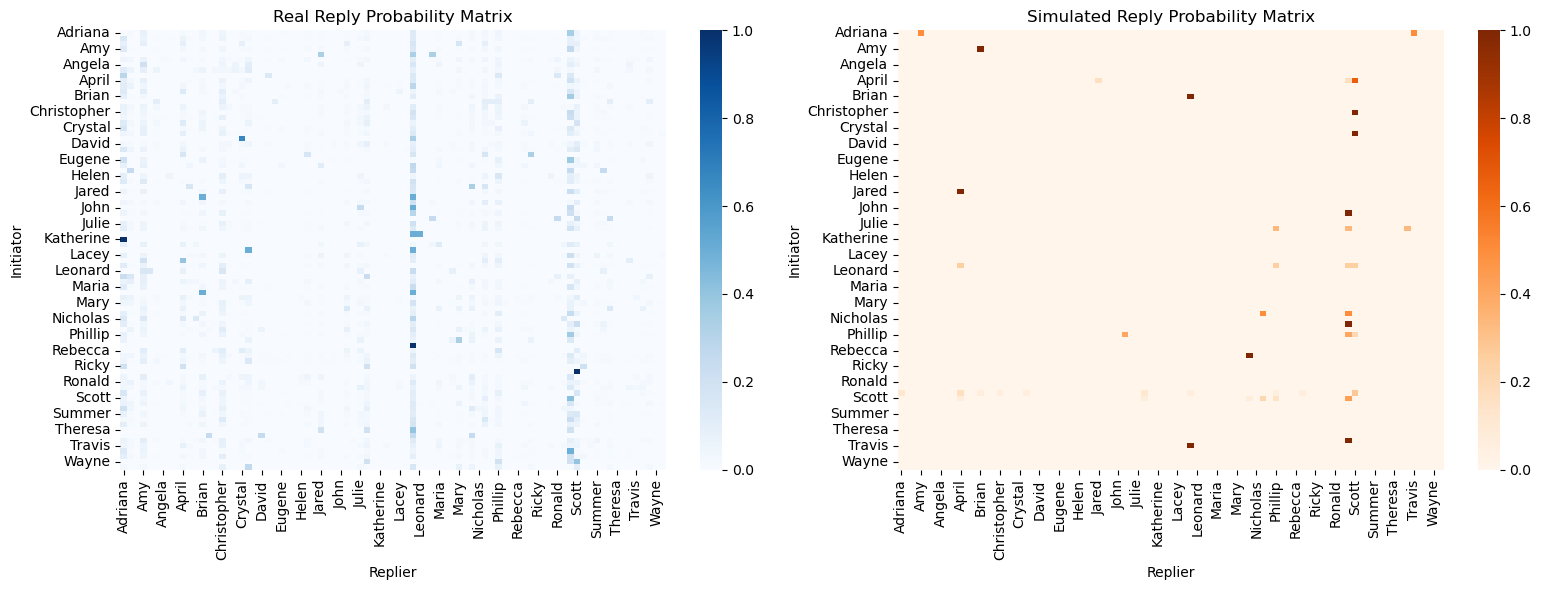

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def build_reply_probability_matrix(df):
    users = df['Sender'].unique()
    reply_counts = pd.DataFrame(0, index=users, columns=users)
    for i in range(1, len(df)):
        prev_sender = df.iloc[i-1]['Sender']
        curr_sender = df.iloc[i]['Sender']
        if prev_sender != curr_sender:
            reply_counts.loc[prev_sender, curr_sender] += 1
    reply_probs = reply_counts.div(reply_counts.sum(axis=1).replace(0, 1), axis=0).fillna(0)
    return reply_probs

def plot_reply_pattern_comparison(real_df, sim_df):
    # Build reply probability matrices
    real_reply_probs = build_reply_probability_matrix(real_df)
    sim_reply_probs = build_reply_probability_matrix(sim_df)

    # Align indices and columns for fair comparison
    all_users = real_reply_probs.index.union(sim_reply_probs.index)
    real_aligned = real_reply_probs.reindex(index=all_users, columns=all_users, fill_value=0)
    sim_aligned = sim_reply_probs.reindex(index=all_users, columns=all_users, fill_value=0)

    # Plot heatmaps side by side
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    sns.heatmap(real_aligned, cmap='Blues', cbar=True)
    plt.title('Real Reply Probability Matrix')
    plt.xlabel('Replier')
    plt.ylabel('Initiator')

    plt.subplot(1, 2, 2)
    sns.heatmap(sim_aligned, cmap='Oranges', cbar=True)
    plt.title('Simulated Reply Probability Matrix')
    plt.xlabel('Replier')
    plt.ylabel('Initiator')

    plt.tight_layout()
    plt.show()

# Example usage:
plot_reply_pattern_comparison(df, sim_df)

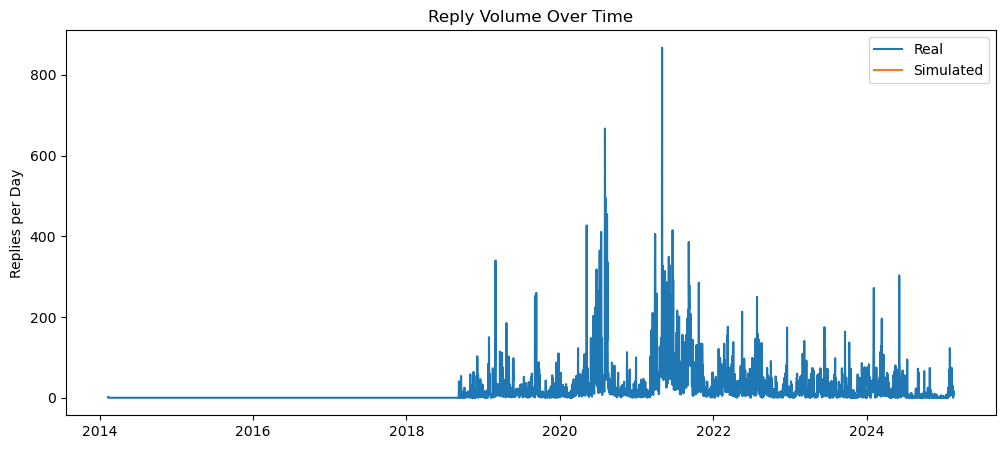

In [29]:
real_time = df.set_index('Timestamp').resample('D').size()
sim_time = sim_df.set_index('Timestamp').resample('D').size()

plt.figure(figsize=(12,5))
plt.plot(real_time.index, real_time.values, label='Real')
plt.plot(sim_time.index, sim_time.values, label='Simulated')
plt.ylabel('Replies per Day')
plt.title('Reply Volume Over Time')
plt.legend()
plt.show()